# Import

In [ ]:
!pip install scikit-learn matplotlib
!pip install PyWavelets
!pip install scipy
!pip install pandas
!pip install seaborn
!pip install lightgbm
!pip install shap

!pip install ipywidgets --upgrade

In [3]:
import os

import pandas as pd

import numpy as np

import time as TIME

# Plot
import matplotlib.pyplot as plt

# Signal processing
from scipy.signal import butter, lfilter, iirnotch, resample

# Feature extraction functions
from scipy.signal import welch
from scipy.stats import skew, kurtosis

# Model
import lightgbm as lgb

# Explainability
import shap

# Features

In [4]:
# comment out any feature to see performance variation

feature_names = [
        'Mean Absolute Value',           # 0
        'Root Mean Square',              # 1
        'Zero Crossings',                # 2
        'Peak Frequency',                # 3
        'Mean Frequency',                # 4
        'Median Frequency',              # 5
        'Total Power',                   # 6
        'Variance',                      # 7
        'Shannon Entropy',               # 8
        'Signal Skewness',               # 9
        'Signal Kurtosis',               # 10
        'Petrosian FD',                  # 11
        'Slope Sign Changes',            # 12
        'Waveform Length',               # 13
        'SNR',                           # 14
        'Recurrence'                     # 15
    ]

# Functions

## Dataset Dictionary

In [5]:
def load_emg_dataset(dataset_path, frequency, record_length):
    """
    Load EMG dataset from directory structure.
    
    Parameters:
    - dataset_path: str, path to the dataset directory
    - frequency: int, sampling frequency in Hz
    - record_length: int, record length in seconds
    
    Returns:
    - dataset: dict, nested dictionary containing EMG data
    """
    expected_samples = frequency * record_length
    
    # Initialize the dataset dictionary
    dataset = {
        'Deltoid': {
            'Healthy': [],
            'Myopathy': [],
            'Neuropathy': []
        },
        'Biceps': {
            'Healthy': [],
            'Myopathy': [],
            'Neuropathy': []
        }
    }
    
    # Mapping from directory names to dictionary keys
    muscle_mapping = {
        '01_Deltoid': 'Deltoid',
        '02_Biceps Brachii': 'Biceps'
    }
    
    condition_dirs = ['Healthy', 'Myopathy', 'Neuropathy']
    
    # Load the data
    for muscle_dir, muscle_key in muscle_mapping.items():
        muscle_path = os.path.join(dataset_path, muscle_dir)
        
        if not os.path.exists(muscle_path):
            continue
        
        for condition in condition_dirs:
            condition_path = os.path.join(muscle_path, condition)
            
            if not os.path.exists(condition_path):
                continue
            
            # Get all .asc files in the condition directory
            asc_files = [f for f in os.listdir(condition_path) if f.endswith('.asc')]
            
            for asc_file in asc_files:
                file_path = os.path.join(condition_path, asc_file)
                
                try:
                    # Read the file and parse the EMG values
                    with open(file_path, 'r') as f:
                        content = f.read()
                        # Split by whitespace and convert to float
                        emg_values = [float(x) for x in content.split()]
                    
                    # Check length and adjust
                    if len(emg_values) < expected_samples:
                        print(f"ERROR - SHORT RECORD: {muscle_key}/{condition}/{asc_file}")
                        continue
                    elif len(emg_values) > expected_samples:
                        emg_values = emg_values[:expected_samples]
                    
                    # Add to dataset
                    dataset[muscle_key][condition].append({
                        'File Name': asc_file,
                        'EMG': emg_values
                    })
                    
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
    
    print("Dataset loaded")
    
    # Display summary
    print("\nDataset Summary:")
    print("="*40)
    for muscle in ['Deltoid', 'Biceps']:
        print(f"{muscle}:")
        for condition in ['Healthy', 'Myopathy', 'Neuropathy']:
            count = len(dataset[muscle][condition])
            print(f"  {condition}: {count} files")
    
    return dataset

## Signal Processing

### EMG Processing

In [6]:
def resample_emg(emg, custom_resampling_factor):
    """
    Resample an EMG signal by a custom factor.
    
    Parameters:
    - emg: list or array, amplitude values
    - custom_resampling_factor: int, factor by which to downsample
    
    Returns:
    - list: resampled EMG signal
    """
    resampled = resample(emg, len(emg) // custom_resampling_factor)
    return resampled.tolist()


def apply_notch_filter(emg, sampling_rate=32768):
    """
    Apply a 50Hz notch filter to an EMG signal.
    
    Parameters:
    - emg: list or array, amplitude values
    - sampling_rate: int, sampling frequency in Hz
    
    Returns:
    - list: filtered EMG signal
    """
    emg_array = np.array(emg)
    nyquist_freq = 0.5 * sampling_rate
    
    notch_freq = 50  # Central frequency of the notch
    quality_factor = 30  # Quality factor for the notch filter
    b_notch, a_notch = iirnotch(notch_freq / nyquist_freq, quality_factor)
    
    filtered = lfilter(b_notch, a_notch, emg_array)
    return filtered.tolist()


def apply_butterworth_filter(emg, custom_low_cut_frequency, custom_high_cut_frequency, 
                            custom_butterworth_order, sampling_rate=32768):
    """
    Apply a Butterworth bandpass filter to an EMG signal.
    
    Parameters:
    - emg: list or array, amplitude values
    - custom_low_cut_frequency: float, low cut-off frequency
    - custom_high_cut_frequency: float, high cut-off frequency
    - custom_butterworth_order: int, order of the Butterworth filter
    - sampling_rate: int, sampling frequency in Hz
    
    Returns:
    - list: filtered EMG signal
    """
    emg_array = np.array(emg)
    nyquist_freq = 0.5 * sampling_rate
    
    low = custom_low_cut_frequency / nyquist_freq
    high = custom_high_cut_frequency / nyquist_freq
    b, a = butter(custom_butterworth_order, [low, high], btype='band')
    
    filtered = lfilter(b, a, emg_array)
    return filtered.tolist()


def process_emg(emg, custom_resampling_factor, custom_low_cut_frequency, 
                custom_high_cut_frequency, custom_butterworth_order):
    """
    Apply complete EMG processing pipeline: Butterworth filter -> Notch filter -> Resampling.
    
    Parameters:
    - emg: list or array, amplitude values
    - custom_resampling_factor: int, factor by which to downsample
    - custom_low_cut_frequency: float, low cut-off frequency for Butterworth filter
    - custom_high_cut_frequency: float, high cut-off frequency for Butterworth filter
    - custom_butterworth_order: int, order of the Butterworth filter
    
    Returns:
    - list: processed EMG signal
    """
    # Apply Butterworth bandpass filter
    filtered = apply_butterworth_filter(emg, custom_low_cut_frequency, 
                                       custom_high_cut_frequency, 
                                       custom_butterworth_order)
    
    # Apply notch filter
    notched = apply_notch_filter(filtered)
    
    # Resample
    resampled = resample_emg(notched, custom_resampling_factor)
    
    return resampled

### Dataset Processing

In [7]:
def process_dataset(dataset, class_option, custom_resampling_factor, custom_low_cut_frequency, 
                   custom_high_cut_frequency, custom_butterworth_order):
    """
    Apply EMG processing to all recordings in the dataset.
    
    Parameters:
    - dataset: dict, nested dictionary with structure dataset[muscle][condition][file_index]
    - custom_resampling_factor: int, factor by which to downsample
    - custom_low_cut_frequency: float, low cut-off frequency for Butterworth filter
    - custom_high_cut_frequency: float, high cut-off frequency for Butterworth filter
    - custom_butterworth_order: int, order of the Butterworth filter
    
    Returns:
    - dict: processed_dataset with same structure as input dataset
    """
    
    
    if class_option == 1:
        processed_dataset = {
            'Deltoid': {
                'Healthy': [],
                'Myopathy': []
            },
            'Biceps': {
                'Healthy': [],
                'Myopathy': []
            }
        }
        
        for muscle in ['Deltoid', 'Biceps']:
            for condition in ['Healthy', 'Myopathy']:
                for file_data in dataset[muscle][condition]:
                    processed_emg = process_emg(
                        file_data['EMG'],
                        custom_resampling_factor,
                        custom_low_cut_frequency,
                        custom_high_cut_frequency,
                        custom_butterworth_order
                    )
                    
                    processed_dataset[muscle][condition].append({
                        'File Name': file_data['File Name'],
                        'EMG': processed_emg
                    })
    elif class_option == 2:

        processed_dataset = {
            'Deltoid': {
                'Healthy': [],
                'Neuropathy': []
            },
            'Biceps': {
                'Healthy': [],
                'Neuropathy': []
            }
        }

        for muscle in ['Deltoid', 'Biceps']:
            for condition in ['Healthy', 'Neuropathy']:
                for file_data in dataset[muscle][condition]:
                    processed_emg = process_emg(
                        file_data['EMG'],
                        custom_resampling_factor,
                        custom_low_cut_frequency,
                        custom_high_cut_frequency,
                        custom_butterworth_order
                    )
                    
                    processed_dataset[muscle][condition].append({
                        'File Name': file_data['File Name'],
                        'EMG': processed_emg
                    })
    
    return processed_dataset

## Feature Vector

In [8]:
def compute_mean_absolute_value(emg):
    """Compute mean absolute value of EMG signal."""
    return np.mean(np.abs(emg))


def compute_root_mean_square(emg):
    """Compute root mean square of EMG signal."""
    return np.sqrt(np.mean(np.array(emg) ** 2))


def compute_zero_crossings(emg):
    """Compute number of zero crossings in EMG signal."""
    return np.sum(np.diff(np.sign(emg)) != 0)


def compute_peak_frequency(emg, freq):
    """Compute peak frequency from power spectral density."""
    emg_array = np.array(emg)
    freqs, psd = welch(emg_array, fs=freq)
    return freqs[np.argmax(psd)]


def compute_mean_frequency(emg, freq):
    """Compute mean frequency from power spectral density."""
    emg_array = np.array(emg)
    freqs, psd = welch(emg_array, fs=freq)
    total_power = np.sum(psd)
    return np.sum(freqs * psd) / total_power


def compute_median_frequency(emg, freq):
    """Compute median frequency from power spectral density."""
    emg_array = np.array(emg)
    freqs, psd = welch(emg_array, fs=freq)
    total_power = np.sum(psd)
    return freqs[np.searchsorted(np.cumsum(psd), 0.5 * total_power)]


def compute_total_power(emg, freq):
    """Compute total power from power spectral density."""
    emg_array = np.array(emg)
    freqs, psd = welch(emg_array, fs=freq)
    return np.sum(psd)


def compute_variance(emg):
    """Compute variance of EMG signal."""
    return np.var(emg)


def compute_shannon_entropy(emg, freq):
    """Compute Shannon entropy from power spectral density."""
    emg_array = np.array(emg)
    freqs, psd = welch(emg_array, fs=freq)
    psd_norm = psd / np.sum(psd)
    return -np.sum(psd_norm * np.log2(psd_norm + 1e-12))


def compute_signal_skewness(emg):
    """Compute skewness of EMG signal."""
    emg_array = np.array(emg)
    return skew(emg_array)


def compute_signal_kurtosis(emg):
    """Compute kurtosis of EMG signal."""
    emg_array = np.array(emg)
    return kurtosis(emg_array)


def compute_petrosian_fd(emg):
    """Compute Petrosian fractal dimension."""
    emg_array = np.array(emg)
    diff = np.diff(emg_array)
    n = len(emg_array)
    return np.log10(n) / (np.log10(n) + np.log10(n / (n + 0.4 * np.sum(np.abs(np.diff(np.sign(diff)))))))


def compute_slope_sign_changes(emg):
    """Compute number of slope sign changes."""
    emg_array = np.array(emg)
    return np.sum(np.diff(np.sign(np.diff(emg_array))) != 0)


def compute_waveform_length(emg):
    """Compute waveform length."""
    emg_array = np.array(emg)
    return np.sum(np.abs(np.diff(emg_array)))


def compute_snr(emg):
    """Compute signal-to-noise ratio."""
    emg_array = np.array(emg)
    signal_power = np.mean(emg_array ** 2)
    noise_power = np.var(emg_array - np.mean(emg_array))
    return 10 * np.log10(signal_power / (noise_power + 1e-12))


def compute_recurrence(emg, freq):
    """Compute recurrence quantification."""
    emg_array = np.array(emg)
    freqs, psd = welch(emg_array, fs=freq)
    return np.sum(psd > (np.mean(psd) + np.std(psd))) / len(psd)

def compute_feature_vector(emg, freq, feature_names):
    """
    Compute complete feature vector for an EMG signal.
    
    Parameters:
    - emg: list or array, EMG amplitude values
    - freq: int, sampling frequency in Hz
    
    Returns:
    - list: feature vector of length 16 with Python float values
    """

    vector = []

    if 'Mean Absolute Value' in feature_names:
        vector.append(float(compute_mean_absolute_value(emg)))
    if 'Root Mean Square' in feature_names:
        vector.append(float(compute_root_mean_square(emg)))
    if 'Zero Crossings' in feature_names:
        vector.append(float(compute_zero_crossings(emg)))
    if 'Peak Frequency' in feature_names:
        vector.append(float(compute_peak_frequency(emg, freq)))
    if 'Mean Frequency' in feature_names:
        vector.append(float(compute_mean_frequency(emg, freq)))
    if 'Median Frequency' in feature_names:
        vector.append(float(compute_median_frequency(emg, freq)))
    if 'Total Power' in feature_names:
        vector.append(float(compute_total_power(emg, freq)))
    if 'Variance' in feature_names:
        vector.append(float(compute_variance(emg)))
    if 'Shannon Entropy' in feature_names:
        vector.append(float(compute_shannon_entropy(emg, freq)))
    if 'Signal Skewness' in feature_names:
        vector.append(float(compute_signal_skewness(emg)))
    if 'Signal Kurtosis' in feature_names:
        vector.append(float(compute_signal_kurtosis(emg)))
    if 'Petrosian FD' in feature_names:
        vector.append(float(compute_petrosian_fd(emg)))
    if 'Slope Sign Changes' in feature_names:
        vector.append(float(compute_slope_sign_changes(emg)))
    if 'Waveform Length' in feature_names:
        vector.append(float(compute_waveform_length(emg)))
    if 'SNR' in feature_names:
        vector.append(float(compute_snr(emg)))
    if 'Recurrence' in feature_names:
        vector.append(float(compute_recurrence(emg, freq)))

    return vector


def extract_features_from_dataset(dataset, class_option, frequency=32768, resampling_factor=1, feature_names=feature_names):
    """
    Extract feature vectors for all EMG signals in the dataset.
    
    Parameters:
    - dataset: dict, nested dictionary with structure dataset[muscle][condition][file_index]
    - frequency: int, original sampling frequency in Hz
    - resampling_factor: int, resampling factor applied to the signals
    
    Returns:
    - dict: dataset with added 'Feature Vector' key for each file
    """
    # Calculate actual sampling rate
    actual_freq = frequency / resampling_factor
    
    # Create new dataset with feature vectors

    if class_option == 1:

        featured_dataset = {
            'Deltoid': {
                'Healthy': [],
                'Myopathy': []
            },
            'Biceps': {
                'Healthy': [],
                'Myopathy': []
            }
        }
        
        for muscle in ['Deltoid', 'Biceps']:
            for condition in ['Healthy', 'Myopathy']:
                for file_data in dataset[muscle][condition]:
                    feature_vector = compute_feature_vector(file_data['EMG'], actual_freq, feature_names=feature_names)
                    
                    featured_dataset[muscle][condition].append({
                        'File Name': file_data['File Name'],
                        'EMG': file_data['EMG'],
                        'Feature Vector': feature_vector
                    })
    
    elif class_option == 2:

        featured_dataset = {
            'Deltoid': {
                'Healthy': [],
                'Neuropathy': []
            },
            'Biceps': {
                'Healthy': [],
                'Neuropathy': []
            }
        }
    
        for muscle in ['Deltoid', 'Biceps']:
            for condition in ['Healthy', 'Neuropathy']:
                for file_data in dataset[muscle][condition]:
                    feature_vector = compute_feature_vector(file_data['EMG'], actual_freq, feature_names=feature_names)
                    
                    featured_dataset[muscle][condition].append({
                        'File Name': file_data['File Name'],
                        'EMG': file_data['EMG'],
                        'Feature Vector': feature_vector
                    })
    
    return featured_dataset

## Dataset Splitting

In [9]:
def create_train_val_test_sets(featured_dataset, class_input, random_seed):
    """
    Create training, validation, and test sets from featured dataset.
    
    Parameters:
    - featured_dataset: dict, dataset with Feature Vectors
    - class_input: int, 1 for Healthy vs Myopathy, 2 for Healthy vs Neuropathy
    
    Returns:
    - tuple: (training_set, validation_set, test_set) as lists of dictionaries
    """
    import random
    random.seed(random_seed)
    
    # Determine which condition to use based on class_input
    if class_input == 1:
        pathology = 'Myopathy'
        # Split sizes for class_input == 1
        splits = {
            'train': {'Deltoid_Healthy': 40, 'Biceps_Healthy': 40, 
                     'Deltoid_Myopathy': 40, 'Biceps_Myopathy': 38},
            'val': {'Deltoid_Healthy': 4, 'Biceps_Healthy': 4, 
                   'Deltoid_Myopathy': 4, 'Biceps_Myopathy': 3},
            'test': {'Deltoid_Healthy': 6, 'Biceps_Healthy': 6, 
                    'Deltoid_Myopathy': 6, 'Biceps_Myopathy': 6}
        }
    elif class_input == 2:
        pathology = 'Neuropathy'
        # Split sizes for class_input == 2
        splits = {
            'train': {'Deltoid_Healthy': 40, 'Biceps_Healthy': 40, 
                     'Deltoid_Neuropathy': 40, 'Biceps_Neuropathy': 40},
            'val': {'Deltoid_Healthy': 4, 'Biceps_Healthy': 4, 
                   'Deltoid_Neuropathy': 4, 'Biceps_Neuropathy': 4},
            'test': {'Deltoid_Healthy': 6, 'Biceps_Healthy': 6, 
                    'Deltoid_Neuropathy': 6, 'Biceps_Neuropathy': 6}
        }
    else:
        raise ValueError("class_input must be 1 or 2")
    
    # Initialize sets
    training_set = []
    validation_set = []
    test_set = []
    
    # Process each muscle and condition
    for muscle in ['Deltoid', 'Biceps']:
        # Process Healthy samples (class 0)
        healthy_samples = featured_dataset[muscle]['Healthy'].copy()
        random.shuffle(healthy_samples)
        
        n_train = splits['train'][f'{muscle}_Healthy']
        n_val = splits['val'][f'{muscle}_Healthy']
        n_test = splits['test'][f'{muscle}_Healthy']
        
        # Split Healthy samples
        train_healthy = healthy_samples[:n_train]
        val_healthy = healthy_samples[n_train:n_train+n_val]
        test_healthy = healthy_samples[n_train+n_val:n_train+n_val+n_test]
        
        # Add to sets with class 0
        for sample in train_healthy:
            training_set.append({
                'File Name': sample['File Name'],
                'Muscle': muscle,
                'Class': 0,
                'EMG': sample['EMG'],
                'Feature Vector': sample['Feature Vector']
            })
        
        for sample in val_healthy:
            validation_set.append({
                'File Name': sample['File Name'],
                'Muscle': muscle,
                'Class': 0,
                'EMG': sample['EMG'],
                'Feature Vector': sample['Feature Vector']
            })
        
        for sample in test_healthy:
            test_set.append({
                'File Name': sample['File Name'],
                'Muscle': muscle,
                'Class': 0,
                'EMG': sample['EMG'],
                'Feature Vector': sample['Feature Vector']
            })
        
        # Process pathology samples (class 1)
        pathology_samples = featured_dataset[muscle][pathology].copy()
        random.shuffle(pathology_samples)
        
        n_train = splits['train'][f'{muscle}_{pathology}']
        n_val = splits['val'][f'{muscle}_{pathology}']
        n_test = splits['test'][f'{muscle}_{pathology}']
        
        # Split pathology samples
        train_pathology = pathology_samples[:n_train]
        val_pathology = pathology_samples[n_train:n_train+n_val]
        test_pathology = pathology_samples[n_train+n_val:n_train+n_val+n_test]
        
        # Add to sets with class 1
        for sample in train_pathology:
            training_set.append({
                'File Name': sample['File Name'],
                'Muscle': muscle,
                'Class': 1,
                'EMG': sample['EMG'],
                'Feature Vector': sample['Feature Vector']
            })
        
        for sample in val_pathology:
            validation_set.append({
                'File Name': sample['File Name'],
                'Muscle': muscle,
                'Class': 1,
                'EMG': sample['EMG'],
                'Feature Vector': sample['Feature Vector']
            })
        
        for sample in test_pathology:
            test_set.append({
                'File Name': sample['File Name'],
                'Muscle': muscle,
                'Class': 1,
                'EMG': sample['EMG'],
                'Feature Vector': sample['Feature Vector']
            })
    
    # Shuffle the final sets
    random.shuffle(training_set)
    random.shuffle(validation_set)
    random.shuffle(test_set)
    
    return training_set, validation_set, test_set

## Data Preparation

In [10]:
def prepare_data_for_lightgbm(training_set, validation_set, test_set, random_seed):
    """
    Prepare data for LightGBM training by shuffling and extracting features and labels.
    
    Parameters:
    - training_set: list of dicts with 'Feature Vector' and 'Class'
    - validation_set: list of dicts with 'Feature Vector' and 'Class'
    - test_set: list of dicts with 'Feature Vector' and 'Class'
    
    Returns:
    - tuple: (shuffled_training_set, shuffled_validation_set, shuffled_test_set,
              X_train, y_train, X_val, y_val, X_test, y_test)
    """
    import random
    random.seed(random_seed)
    
    # Create copies and shuffle
    shuffled_training_set = training_set.copy()
    shuffled_validation_set = validation_set.copy()
    shuffled_test_set = test_set.copy()
    
    random.shuffle(shuffled_training_set)
    random.shuffle(shuffled_validation_set)
    random.shuffle(shuffled_test_set)
    
    # Extract features and labels
    X_train = [sample['Feature Vector'] for sample in shuffled_training_set]
    y_train = [sample['Class'] for sample in shuffled_training_set]
    
    X_val = [sample['Feature Vector'] for sample in shuffled_validation_set]
    y_val = [sample['Class'] for sample in shuffled_validation_set]
    
    X_test = [sample['Feature Vector'] for sample in shuffled_test_set]
    y_test = [sample['Class'] for sample in shuffled_test_set]
    
    return (shuffled_training_set, shuffled_validation_set, shuffled_test_set,
            X_train, y_train, X_val, y_val, X_test, y_test)

## LightGBM Training

In [11]:
def train_lightgbm(X_train, y_train, X_val, y_val, hyperparams):
    """
    Train a LightGBM model.
    
    Parameters:
    - X_train: list of feature vectors for training
    - y_train: list of class labels for training
    - X_val: list of feature vectors for validation
    - y_val: list of class labels for validation
    - hyperparams: dict of hyperparameters for LightGBM
    
    Returns:
    - model: trained LightGBM model
    """
    
    # Convert lists to numpy arrays
    X_train_array = np.array(X_train)
    y_train_array = np.array(y_train)
    X_val_array = np.array(X_val)
    y_val_array = np.array(y_val)
    
    # Create datasets
    dtrain = lgb.Dataset(X_train_array, label=y_train_array)
    dval = lgb.Dataset(X_val_array, label=y_val_array, reference=dtrain)
    
    # Extract num_boost_round if present, otherwise use default
    hyperparams_copy = hyperparams.copy()
    num_boost_round = hyperparams_copy.pop('num_boost_round', 500)
    
    # Train model
    model = lgb.train(
        params=hyperparams_copy,
        train_set=dtrain,
        num_boost_round=num_boost_round,
        valid_sets=[dtrain, dval],
        valid_names=['train', 'val']
    )
    
    return model

## LightGBM Evaluation

In [12]:
def evaluate_lightgbm(model, X_test, y_test):
    """
    Evaluate a LightGBM model on test data.
    
    Parameters:
    - model: trained LightGBM model
    - X_test: list of feature vectors for testing
    - y_test: list of class labels for testing
    
    Returns:
    - dict: dictionary with 'Accuracy', 'Sensitivity', 'Specificity'
    """
    # Make predictions
    y_pred_proba = model.predict(X_test)
    
    # Convert probabilities to class predictions
    # For multiclass, take argmax; for binary, can use threshold
    if len(y_pred_proba.shape) > 1 and y_pred_proba.shape[1] > 1:
        y_pred = np.argmax(y_pred_proba, axis=1)
    else:
        y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Convert to numpy arrays
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)
    
    # Calculate metrics
    # True Positives, True Negatives, False Positives, False Negatives
    tp = np.sum((y_test == 1) & (y_pred == 1))
    tn = np.sum((y_test == 0) & (y_pred == 0))
    fp = np.sum((y_test == 0) & (y_pred == 1))
    fn = np.sum((y_test == 1) & (y_pred == 0))
    
    # Accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    # Sensitivity (True Positive Rate, Recall)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    
    # Specificity (True Negative Rate)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    
    return {
        'Accuracy': float(accuracy),
        'Sensitivity': float(sensitivity),
        'Specificity': float(specificity)
    }

## SHAP

In [13]:
def compute_shap_values(model, X_test):
    """
    Compute SHAP values for a LightGBM model.
    
    Parameters:
    - model: trained LightGBM model
    - X_test: list of feature vectors for testing
    - feature_names: list of feature names (length 16)
    
    Returns:
    - tuple: (shap_values_class_0, shap_values_class_1, explainer)
             shap_values are numpy arrays of shape (n_samples, n_features)
             explainer is the SHAP TreeExplainer object
    """
    import shap
    
    # Convert X_test to numpy array
    X_test_array = np.array(X_test)
    
    # Initialize SHAP explainer
    explainer = shap.TreeExplainer(model)
    
    # Calculate SHAP values
    shap_values = explainer.shap_values(X_test_array)
    
    print("SHAP values computed")
    
    # Extract class-specific SHAP arrays
    # Reshape from (samples, features, 2) to (samples, features) for each class
    shap_values_class_0 = np.array([[row[j][0] for j in range(len(row))] for row in shap_values])
    shap_values_class_1 = np.array([[row[j][1] for j in range(len(row))] for row in shap_values])
    
    return shap_values_class_0, shap_values_class_1, explainer

In [44]:
def plot_shap_feature_importance(shap_values_class_1, feature_names, title='SHAP Feature Importance', 
                                 save_path=None):
    """
    Plot SHAP feature importance with enhanced visualization.
    
    Parameters:
    - shap_values_class_1: numpy array of SHAP values for class 1 (n_samples, n_features)
    - feature_names: list of feature names (length 16)
    - title: str, title for the plot
    - save_path: str, path to save the figure (optional)
    """
    
    # Calculate mean absolute SHAP values
    mean_abs_shap = np.abs(shap_values_class_1).mean(axis=0)
    
    # Create DataFrame in feature order (0-15)
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Mean |SHAP|': mean_abs_shap
    })
    
    # Print sorted table
    feature_importance_sorted = feature_importance.sort_values('Mean |SHAP|', ascending=False)
    print("\nFeature Importance (sorted by SHAP value):")
    print("=" * 60)
    print(feature_importance_sorted.to_string(index=False))
    print("=" * 60)
    
    # Create plot with feature order (0-15, bottom to top, so reverse for plotting)
    fig, ax = plt.subplots(figsize=(12, 9))
    
    # Reverse the order so Feature 0 is at top
    feature_importance_reversed = feature_importance.iloc[::-1].reset_index(drop=True)
    
    # Create bars with gradient color based on importance
    bars = ax.barh(feature_importance_reversed['Feature'], feature_importance_reversed['Mean |SHAP|'], 
                   color='steelblue', edgecolor='navy', linewidth=1.2, alpha=0.8)
    
    # Add value labels inside bars, near the tip
    for i, (bar, value) in enumerate(zip(bars, feature_importance_reversed['Mean |SHAP|'])):
        width = bar.get_width()
        if value > 0.05:
            # Place text inside the bar, 5% from the right edge
            ax.text(width - 0.005, 
                    bar.get_y() + bar.get_height() / 2,
                    f'{value:.4f}',
                    ha='right', va='center', fontsize=9, fontweight='bold', color='white')
        else:
            # Place text outside the bar, 5% from the right edge
            ax.text(width + 0.04, 
                    bar.get_y() + bar.get_height() / 2,
                    f'{value:.4f}',
                    ha='right', va='center', fontsize=9, fontweight='bold', color='steelblue')
        
    
    # Styling
    ax.set_xlabel('Mean |SHAP value|', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.7)
    
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\nPlot saved to: {save_path}")
    
    plt.show()

In [45]:
def plot_shap_summary(shap_values_class_1, X_test, feature_names, title='SHAP Summary Plot', 
                     save_path=None):
    """
    Plot SHAP summary (beeswarm) plot showing feature impact distribution.
    
    This plot shows:
    - X-axis: SHAP value (impact on prediction)
      * Positive values (right) push prediction toward class 1
      * Negative values (left) push prediction toward class 0
      * Zero (vertical line) means no impact
    - Y-axis: Features in order (0 at top, 15 at bottom)
    - Color: Feature value (red = high, blue = low)
      * Red dots: High feature values
      * Blue dots: Low feature values
    - Each dot: One sample from the test set
    
    Key insights:
    - If red dots are on the right: High feature values increase class 1 probability
    - If blue dots are on the right: Low feature values increase class 1 probability
    - Wide spread: Feature has variable impact across samples
    - Narrow spread: Feature has consistent impact
    
    Parameters:
    - shap_values_class_1: numpy array of SHAP values for class 1 (n_samples, n_features)
    - X_test: list or array of feature vectors (n_samples, n_features)
    - feature_names: list of feature names (length 16)
    - title: str, title for the plot
    - save_path: str, path to save the figure (optional)
    """
    
    # Convert X_test to numpy array if needed
    X_test_array = np.array(X_test)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Feature indices in reverse order (so 0 is at top)
    feature_indices = np.arange(len(feature_names))[::-1]
    
    # Plot each feature
    for plot_idx, feature_idx in enumerate(feature_indices):
        # Add jitter to y-axis for better visibility
        y_jitter = np.random.normal(plot_idx, 0.04, size=len(shap_values_class_1))
        
        # Get feature values for coloring
        color_vals = X_test_array[:, feature_idx]
        
        # Create scatter plot
        scatter = ax.scatter(shap_values_class_1[:, feature_idx], y_jitter, 
                           c=color_vals, cmap='coolwarm', alpha=0.6, s=50, 
                           edgecolors='black', linewidth=0.5)
    
    # Set y-axis labels (reversed feature names)
    ax.set_yticks(range(len(feature_names)))
    ax.set_yticklabels(feature_names[::-1])
    
    # Labels and styling
    ax.set_xlabel('SHAP value (impact on class 1 prediction)', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.7)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax, label='Feature Value')
    cbar.set_label('Feature Value\n(Red=High, Blue=Low)', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\nPlot saved to: {save_path}")
    
    plt.show()

In [46]:
def plot_force_plot(model, class_option, shap_values_class_1, X_test, shuffled_test_set, feature_names, 
                   sample_idx, explainer, save_path=None):
    """
    Plot SHAP force plot for a single test sample.
    
    Parameters:
    - model: trained LightGBM model
    - shap_values_class_1: numpy array of SHAP values for class 1
    - X_test: list or array of feature vectors
    - shuffled_test_set: list of dicts with 'File Name', 'Class', etc.
    - feature_names: list of feature names (length 16)
    - sample_idx: int, index of the sample to plot
    - explainer: SHAP TreeExplainer object
    - save_path: str, path to save the figure (optional)
    
    Returns:
    - list: SHAP values for the sample
    """
    
    # Convert X_test to numpy array if needed
    X_test_array = np.array(X_test)
    
    # Get sample information
    sample_info = shuffled_test_set[sample_idx]
    file_name = sample_info['File Name']
    true_class = sample_info['Class']
    
    # Get prediction
    pred_proba = model.predict([X_test_array[sample_idx]])[0]
    pred_class = int(pred_proba[1] > 0.5) if len(pred_proba) > 1 else int(pred_proba > 0.5)
    
    # Get expected value (base rate)
    expected_value_class_1 = explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value
    
    # Print sample information
    print("=" * 70)
    print(f"SAMPLE {sample_idx} ANALYSIS")
    print("=" * 70)
    print(f"File Name: {file_name}")
    if class_option == 1:
        print(f"True Class: {true_class} ({'Healthy' if true_class == 0 else 'Myopathy'})")
        print(f"Predicted Class: {pred_class} ({'Healthy' if pred_class == 0 else 'Myopathy'})")
    else:
        print(f"True Class: {true_class} ({'Healthy' if true_class == 0 else 'Neuropathy'})")
        print(f"Predicted Class: {pred_class} ({'Healthy' if pred_class == 0 else 'Neuropathy'})")

    if len(pred_proba) > 1:
        print(f"Prediction Probabilities: Class 0={pred_proba[0]:.5f}, Class 1={pred_proba[1]:.5f}")
    else:
        print(f"Prediction Probability: {pred_proba:.5f}")
    print(f"Base rate (expected value): {expected_value_class_1:.4f}")
    print("=" * 70)
    
    # Get feature values and SHAP values for this sample
    feature_vals = X_test_array[sample_idx]
    shap_vals = shap_values_class_1[sample_idx]
    
    # Create contributions dataframe
    contributions = pd.DataFrame({
        'Feature': feature_names,
        'Value': feature_vals,
        'SHAP': shap_vals,
        'Impact': ['↑' if s > 0 else '↓' for s in shap_vals]
    })
    
    print("\nFeature Contributions:")
    print(contributions.to_string(index=False))
    print("=" * 70)
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Reverse order so feature 0 is at top
    contributions_reversed = contributions.iloc[::-1].reset_index(drop=True)
    
    # Color based on contribution direction
    colors = ['red' if x < 0 else 'blue' for x in contributions_reversed['SHAP']]
    
    # Create bars
    bars = ax.barh(contributions_reversed['Feature'], contributions_reversed['SHAP'], color=colors, alpha=0.7)
    
    # Add value labels
    for bar, shap_val in zip(bars, contributions_reversed['SHAP']):
        width = bar.get_width()
        if width >= 0:
            ax.text(width + max(contributions_reversed['SHAP']) * 0.01,
                   bar.get_y() + bar.get_height() / 2,
                   f'{shap_val:.4f}',
                   ha='left', va='center', fontsize=8, fontweight='bold')
        else:
            ax.text(width - abs(min(contributions_reversed['SHAP'])) * 0.01,
                   bar.get_y() + bar.get_height() / 2,
                   f'{shap_val:.4f}',
                   ha='right', va='center', fontsize=8, fontweight='bold')
    
    # Styling
    ax.set_xlabel('SHAP value contribution', fontsize=12, fontweight='bold')
    if class_option == 1:
        ax.set_title(f'Sample {sample_idx} - Feature Contributions to Prediction\n'
                    f'True: {"Healthy" if true_class == 0 else "Myopathy"} | '
                    f'Predicted: {"Healthy" if pred_class == 0 else "Myopathy"}',
                    fontsize=14, fontweight='bold', pad=20)
    else:
        ax.set_title(f'Sample {sample_idx} - Feature Contributions to Prediction\n'
                    f'True: {"Healthy" if true_class == 0 else "Neuropathy"} | '
                    f'Predicted: {"Healthy" if pred_class == 0 else "Neuropathy"}',
                    fontsize=14, fontweight='bold', pad=20)

    ax.axvline(x=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.7)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='blue', alpha=0.7, label='Pushes toward Class 1'),
                      Patch(facecolor='red', alpha=0.7, label='Pushes toward Class 0')]
    ax.legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}\n")
    
    plt.show()
    
    # Return SHAP values for this sample
    return shap_vals.tolist()

In [47]:
def count_correct_pushes(shap_values_class_0, shap_values_class_1, y_test, feature_names):
    """
    Count how many times each feature pushes the prediction toward the correct class.
    
    For each test sample:
    - If true class is 0: count features with negative SHAP values (pushing toward class 0)
    - If true class is 1: count features with positive SHAP values (pushing toward class 1)
    
    Parameters:
    - shap_values_class_0: numpy array of SHAP values for class 0 (n_samples, n_features)
    - shap_values_class_1: numpy array of SHAP values for class 1 (n_samples, n_features)
    - y_test: list or array of true class labels
    - feature_names: list of feature names (length 16)
    
    Returns:
    - list: count of correct pushes for each feature
    """
    y_test_array = np.array(y_test)
    n_features = len(feature_names)
    n_samples = len(y_test_array)
    
    # Initialize counter for each feature
    correct_pushes = [0] * n_features
    
    # Iterate over all samples
    for i in range(n_samples):
        true_class = y_test_array[i]
        
        if true_class == 0:
            # For class 0: negative SHAP values push toward correct class
            shap_vals = shap_values_class_1[i]  # Using class 1 SHAP values
            for j in range(n_features):
                if shap_vals[j] < 0:  # Negative pushes toward class 0
                    correct_pushes[j] += 1
        else:
            # For class 1: positive SHAP values push toward correct class
            shap_vals = shap_values_class_1[i]
            for j in range(n_features):
                if shap_vals[j] > 0:  # Positive pushes toward class 1
                    correct_pushes[j] += 1
    
    # Print results
    print("\n" + "=" * 70)
    print("FEATURE CORRECT PUSH COUNTS")
    print("=" * 70)
    print(f"Total test samples: {n_samples}")
    print(f"\nHow many times each feature pushed toward the CORRECT class:")
    print("-" * 70)
    for feature_name, count in zip(feature_names, correct_pushes):
        percentage = (count / n_samples) * 100
        print(f"{feature_name:25s}: {count:3d} / {n_samples} ({percentage:5.1f}%)")
    print("=" * 70)
    
    return correct_pushes

## EMG Plot

In [14]:
def plot_emg(emg, frequency=32768, resampling_factor=1):
    """
    Plot an EMG signal.
    
    Parameters:
    - emg: list or array, amplitude values in microVolts
    - frequency: int, original sampling frequency in Hz (default: 32768)
    - resampling_factor: int, resampling factor applied to the signal (default: 1 for no resampling)
    """
    
    # Calculate actual sampling rate after resampling
    actual_sampling_rate = frequency / resampling_factor
    
    # Create time axis
    num_samples = len(emg)
    time = np.linspace(0, 5, num_samples)
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(time, emg, linewidth=0.5)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude (μV)')
    plt.title('EMG Signal')
    plt.xlim(0, 5)
    plt.ylim(-2000, 2000)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## Statistics

In [15]:
def compute_statistics_by_metric(feature_vectors):
    """
    Compute statistics across all features for a set of feature vectors.
    
    Parameters:
    - feature_vectors: list of lists, each inner list is a feature vector of length 16
    
    Returns:
    - dict: dictionary with 5 keys (metrics), each containing a list of 16 values
    """
    # Convert to numpy array for easier computation
    features_array = np.array(feature_vectors)
    
    return {
        'Mean': np.mean(features_array, axis=0).tolist(),
        'Variance': np.var(features_array, axis=0).tolist(),
        'Median': np.median(features_array, axis=0).tolist(),
        'Max': np.max(features_array, axis=0).tolist(),
        'Min': np.min(features_array, axis=0).tolist()
    }


def compute_statistics_by_feature(feature_vectors, feature_names):
    """
    Compute statistics for each individual feature across a set of feature vectors.
    
    Parameters:
    - feature_vectors: list of lists, each inner list is a feature vector of length 16
    
    Returns:
    - dict: dictionary with 16 keys (feature names), each containing a list of 5 statistics
    """
    # Convert to numpy array for easier computation
    features_array = np.array(feature_vectors)
    
    
    statistics = {}
    
    for idx, feature_name in enumerate(feature_names):
        feature_column = features_array[:, idx]
        statistics[feature_name] = [
            float(np.mean(feature_column)),      # Mean
            float(np.var(feature_column)),       # Variance
            float(np.median(feature_column)),    # Median
            float(np.max(feature_column)),       # Max
            float(np.min(feature_column))        # Min
        ]
    
    return statistics

# Main

## Load Dataset

In [16]:
# Load the dataset
dataset_path = r'C:\Users\aziz\Projet_ML_ISEP\data\EMG Dataset Repository'
frequency = 32768
record_length = 5

dataset = load_emg_dataset(dataset_path, frequency, record_length)

Dataset loaded

Dataset Summary:
Deltoid:
  Healthy: 50 files
  Myopathy: 50 files
  Neuropathy: 50 files
Biceps:
  Healthy: 50 files
  Myopathy: 47 files
  Neuropathy: 50 files


In [17]:
print(dataset.keys())
print(dataset['Deltoid'].keys())
print(dataset['Deltoid']['Healthy'][0])

for muscle in dataset.keys():
    for condition in dataset[muscle].keys():
        for i in range(len(dataset[muscle][condition])):
            if len(dataset[muscle][condition][i]['EMG']) != frequency*record_length:
                print("error")


dict_keys(['Deltoid', 'Biceps'])
dict_keys(['Healthy', 'Myopathy', 'Neuropathy'])
{'File Name': 'EMG _001 _01_ RD_Hea.asc', 'EMG': [651.6, 655.5, 661.7, 659.4, 657.8, 660.2, 668.8, 672.7, 681.3, 686.7, 691.4, 702.3, 714.8, 734.4, 745.3, 760.9, 781.3, 801.6, 823.4, 842.2, 860.9, 871.1, 879.7, 889.8, 882.8, 864.1, 840.6, 806.3, 776.6, 739.8, 698.4, 651.6, 607.8, 560.9, 511.7, 470.3, 413.3, 361.7, 317.2, 264.8, 203.9, 143.8, 76.6, -2.3, -97.7, -182.0, -259.4, -326.6, -375.0, -419.5, -459.4, -503.1, -539.1, -580.5, -622.7, -664.8, -710.2, -743.0, -780.5, -811.7, -846.9, -877.3, -900.0, -921.9, -938.3, -952.3, -960.9, -968.8, -974.2, -977.3, -978.1, -978.9, -975.8, -974.2, -969.5, -967.2, -960.2, -945.3, -930.5, -924.2, -911.7, -892.2, -870.3, -855.5, -838.3, -818.0, -796.9, -778.9, -761.7, -739.1, -721.1, -704.7, -682.8, -661.7, -647.7, -626.6, -604.7, -585.2, -566.4, -557.8, -538.3, -514.8, -499.2, -486.7, -470.3, -450.0, -433.6, -414.1, -397.7, -382.8, -370.3, -350.8, -343.0, -329.7, -31

## Signal Processing

In [20]:
# class_option = 1 : Hea vs Myo
# class_option = 2 : Hea vs Neu
class_option = 1    

# [resampling factor, low cut freq, high cut freq, butterworth order]
if class_option == 1:
    best_combination = [2, 20, 2000, 3]
    task_name = 'Healthy vs. Myopathy'
    number_of_files = len(dataset['Deltoid']['Healthy']) + len(dataset['Biceps']['Healthy']) + len(dataset['Deltoid']['Myopathy']) + len(dataset['Biceps']['Myopathy'])
elif class_option == 2:
    best_combination = [16, 20, 1000, 1]
    task_name = 'Healthy vs. Neuropathy'
    number_of_files = len(dataset['Deltoid']['Healthy']) + len(dataset['Biceps']['Healthy']) + len(dataset['Deltoid']['Neuropathy']) + len(dataset['Biceps']['Neuropathy'])

print(number_of_files)

random_seed = 20
custom_resampling_factor = best_combination[0]
custom_low_cut_frequency = best_combination[1]
custom_high_cut_frequency = best_combination[2]
custom_butterworth_order = best_combination[3]

197


In [21]:
start = TIME.time()

processed_dataset = process_dataset(dataset, class_option, custom_resampling_factor, custom_low_cut_frequency, 
                   custom_high_cut_frequency, custom_butterworth_order)

end = TIME.time()

signal_processing_time = (end-start)/number_of_files

print(signal_processing_time)

0.029794959247414834


## Feature Vectors

In [22]:
start = TIME.time()

featured_dataset = extract_features_from_dataset(processed_dataset, class_option, frequency, custom_resampling_factor, feature_names=feature_names)

end = TIME.time()

features_extraction_time = (end-start)/number_of_files

print(features_extraction_time)

0.16348181279177593


In [23]:
print(featured_dataset['Deltoid']['Healthy'][0]['Feature Vector'])
print(len(featured_dataset['Deltoid']['Healthy'][0]['Feature Vector']))

[242.8109721663437, 321.81826282242287, 1916.0, 128.0, 188.99022593003107, 128.0, 1587.890654982192, 103566.98125443904, 2.8779581904801446, -0.6632374826515306, 1.5631573237273821, 1.0033081470107306, 3892.0, 1597743.6316968235, 5.464630562797911e-07, 0.046511627906976744]
16


## EMG Plot

EMG _001 _01_ RD_Hea.asc
[242.81097208245637, 321.8182627865607, 1916.0, 128.0, 188.99022593274893, 128.0, 1587.890654957667, 103566.98123154316, 2.8779581904334477, -0.6632374823495194, 1.5631573271656602, 1.0033081470107306, 3892.0, 1597743.6316438664, 5.464552442639675e-07, 0.046511627906976744]


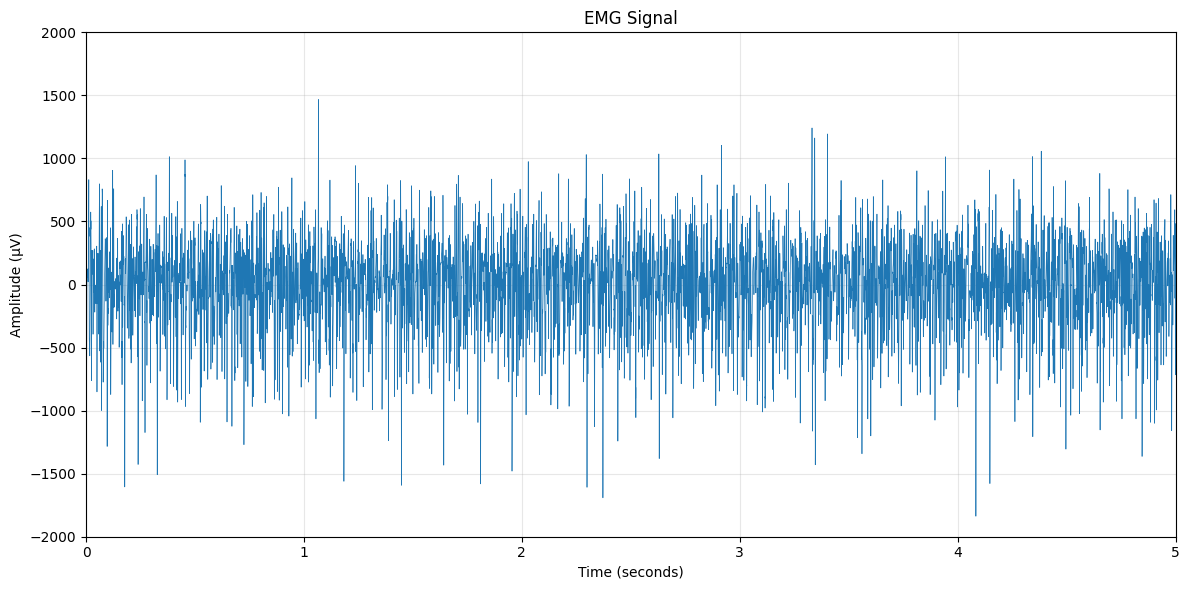

In [96]:
print(featured_dataset['Deltoid']['Healthy'][0]['File Name'])
print(featured_dataset['Deltoid']['Healthy'][0]['Feature Vector'])
plot_emg(featured_dataset['Deltoid']['Healthy'][0]['EMG'], frequency, resampling_factor=custom_resampling_factor)

## Statistics (ignore this part or improve it) // I added 3 plots and interpreted them 

### Statistical Sets

In [24]:
healthy_deltoid_vectors = []
myopathy_deltoid_vectors = []
neuropathy_deltoid_vectors = []

for i in range(len(featured_dataset['Deltoid']['Healthy'])):
    healthy_deltoid_vectors.append(featured_dataset['Deltoid']['Healthy'][i]['Feature Vector'])
if class_option == 1:
    for i in range(len(featured_dataset['Deltoid']['Myopathy'])):
        myopathy_deltoid_vectors.append(featured_dataset['Deltoid']['Myopathy'][i]['Feature Vector'])
elif class_option == 2:
    for i in range(len(featured_dataset['Deltoid']['Neuropathy'])):
        neuropathy_deltoid_vectors.append(featured_dataset['Deltoid']['Neuropathy'][i]['Feature Vector'])

healthy_biceps_vectors = []
myopathy_biceps_vectors = []
neuropathy_biceps_vectors = []

for i in range(len(featured_dataset['Biceps']['Healthy'])):
    healthy_biceps_vectors.append(featured_dataset['Biceps']['Healthy'][i]['Feature Vector'])
if class_option == 1:
    for i in range(len(featured_dataset['Biceps']['Myopathy'])):
        myopathy_biceps_vectors.append(featured_dataset['Biceps']['Myopathy'][i]['Feature Vector'])
elif class_option == 2:
    for i in range(len(featured_dataset['Biceps']['Neuropathy'])):
        neuropathy_biceps_vectors.append(featured_dataset['Biceps']['Neuropathy'][i]['Feature Vector'])


healthy_vectors = healthy_deltoid_vectors + healthy_biceps_vectors
myopathy_vectors = myopathy_deltoid_vectors + myopathy_biceps_vectors
neuropathy_vectors = neuropathy_deltoid_vectors + neuropathy_biceps_vectors

print(len(healthy_vectors))
print(len(myopathy_vectors))
print(len(neuropathy_vectors))


100
97
0


### Compute metrics

In [25]:
healthy_metrics = compute_statistics_by_metric(healthy_vectors)
if class_option == 1:
    myopathy_metrics = compute_statistics_by_metric(myopathy_vectors)
elif class_option == 2:
    neuropathy_metrics = compute_statistics_by_metric(neuropathy_vectors)

print(healthy_metrics.keys())

dict_keys(['Mean', 'Variance', 'Median', 'Max', 'Min'])


In [26]:
healthy_features = compute_statistics_by_feature(healthy_vectors, feature_names)
if class_option == 1:
    myopathy_features = compute_statistics_by_feature(myopathy_vectors, feature_names)
if class_option == 2:
    neuropathy_features = compute_statistics_by_feature(neuropathy_vectors, feature_names)

print(healthy_features.keys())

dict_keys(['Mean Absolute Value', 'Root Mean Square', 'Zero Crossings', 'Peak Frequency', 'Mean Frequency', 'Median Frequency', 'Total Power', 'Variance', 'Shannon Entropy', 'Signal Skewness', 'Signal Kurtosis', 'Petrosian FD', 'Slope Sign Changes', 'Waveform Length', 'SNR', 'Recurrence'])


In [27]:
print('Mean===================================================================================================')
print(healthy_metrics['Mean'])
if class_option == 1:
    print(myopathy_metrics['Mean'])
else:
    print(neuropathy_metrics['Mean'])
print('Max====================================================================================================')
print(healthy_metrics['Max'])
if class_option == 1:
    print(myopathy_metrics['Max'])
else:
    print(neuropathy_metrics['Max'])
print('Min====================================================================================================')
print(healthy_metrics['Min'])
if class_option == 1:
    print(myopathy_metrics['Min'])
else:
    print(neuropathy_metrics['Min'])

Mean===================================================================================================
[127.90423427179434, 181.5944236079561, 1857.37, 98.56, 217.38695201854426, 165.76, 616.477107082803, 41701.474208434716, 3.056352084868889, -0.45428529594736683, 5.140326474450361, 1.005550409834056, 6612.62, 885865.3481821906, 5.95650863013622e-07, 0.04945736434108532]
[146.4345493281705, 209.18655370088456, 2376.8762886597938, 114.14432989690722, 261.1599670945548, 188.70103092783506, 850.9541903091248, 58881.62854001716, 3.321351278107076, -0.5180139541870854, 5.588620920544303, 1.0066030610878176, 7909.731958762886, 1264789.2067404047, 5.5857838743690765e-06, 0.05314472948133948]
Max====================================================================================================
[418.0553728860906, 568.7193209354506, 2684.0, 256.0, 448.56461829449484, 384.0, 4762.359909080051, 323441.66503824777, 4.194601624829135, 1.1333556611015574, 21.100566424828887, 1.0102544379334628, 1

### Compare average feature values (bar chart)

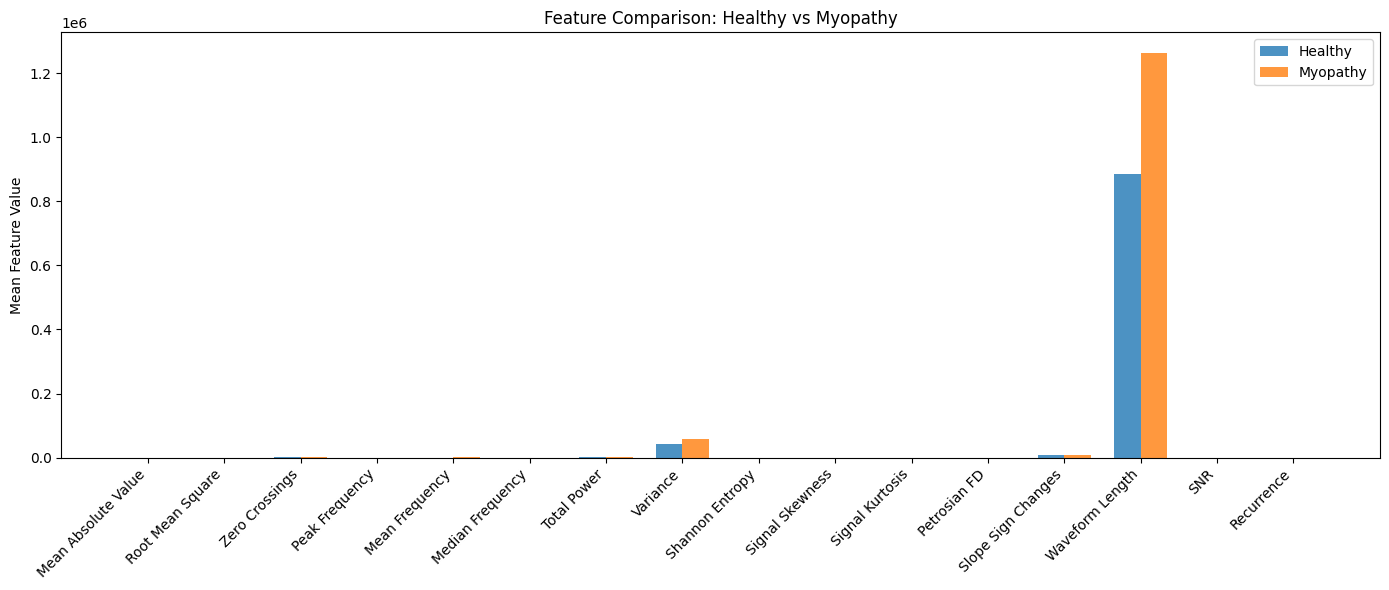

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Convert to DataFrame for plotting
healthy_mean = np.array(healthy_metrics['Mean'])
if class_option == 1:
    pathology_mean = np.array(myopathy_metrics['Mean'])
    pathology_name = "Myopathy"
else:
    pathology_mean = np.array(neuropathy_metrics['Mean'])
    pathology_name = "Neuropathy"

df_compare = pd.DataFrame({
    'Feature': feature_names,
    'Healthy Mean': healthy_mean,
    f'{pathology_name} Mean': pathology_mean
})

# Plot side-by-side bar chart
plt.figure(figsize=(14, 6))
x = np.arange(len(df_compare))
width = 0.35
plt.bar(x - width/2, df_compare['Healthy Mean'], width, label='Healthy', alpha=0.8)
plt.bar(x + width/2, df_compare[f'{pathology_name} Mean'], width, label=pathology_name, alpha=0.8)

plt.xticks(x, df_compare['Feature'], rotation=45, ha='right')
plt.ylabel('Mean Feature Value')
plt.title(f'Feature Comparison: Healthy vs {pathology_name}')
plt.legend()
plt.tight_layout()
plt.show()


### Boxplots for top 5 most discriminative features

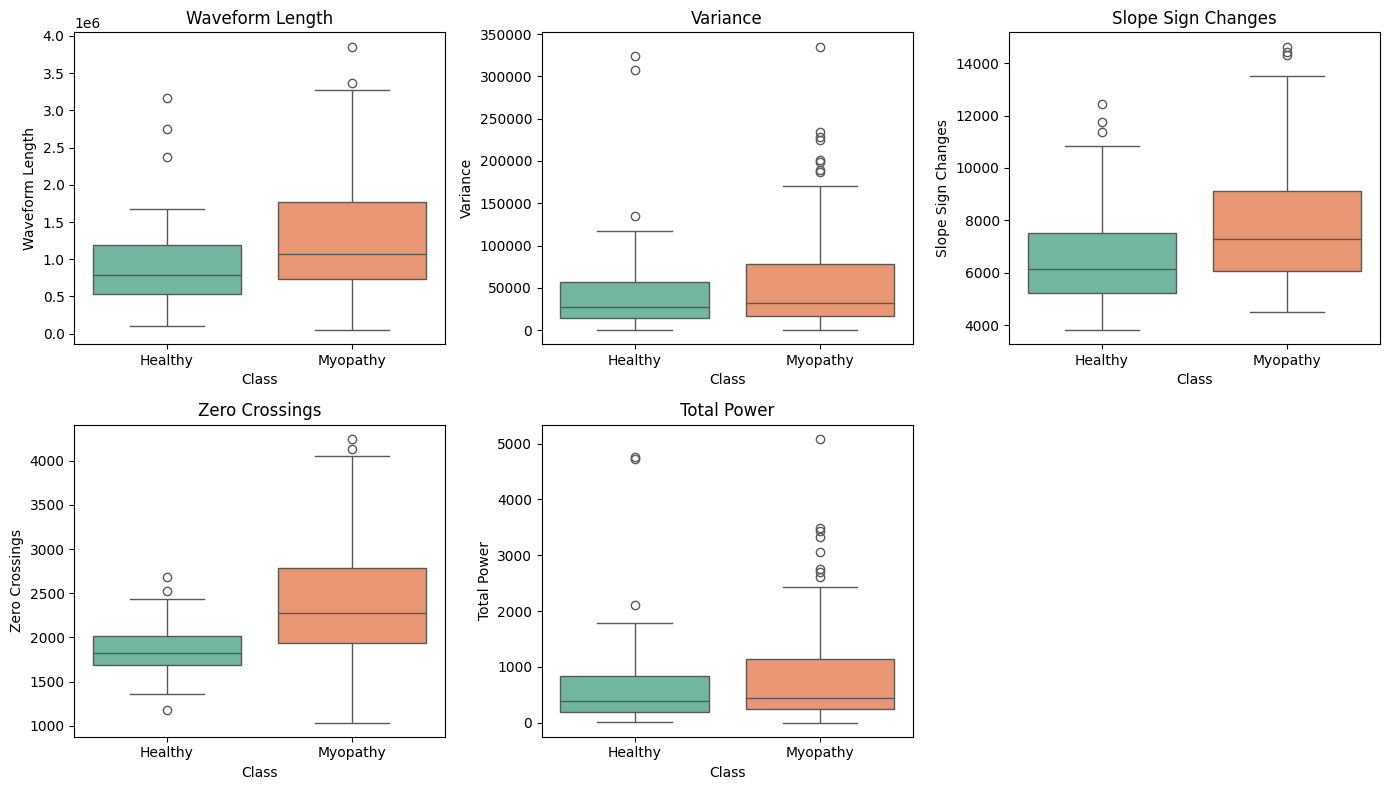

In [35]:
import seaborn as sns

# Combine data for plotting
if class_option == 1:
    combined_vectors = healthy_vectors + myopathy_vectors
    labels = ['Healthy'] * len(healthy_vectors) + ['Myopathy'] * len(myopathy_vectors)
else:
    combined_vectors = healthy_vectors + neuropathy_vectors
    labels = ['Healthy'] * len(healthy_vectors) + ['Neuropathy'] * len(neuropathy_vectors)

df_all = pd.DataFrame(combined_vectors, columns=feature_names)
df_all['Class'] = labels

# Plot the 5 features with largest mean differences
mean_diff = np.abs(np.array(healthy_metrics['Mean']) - pathology_mean)
top5_idx = np.argsort(mean_diff)[-5:][::-1]
top5_features = [feature_names[i] for i in top5_idx]

plt.figure(figsize=(14, 8))
for i, feat in enumerate(top5_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Class', y=feat, hue='Class', data=df_all, palette='Set2', legend=False)
    plt.title(f'{feat}')
plt.tight_layout()
plt.show()


### Correlation heatmap (within Healthy vs Pathology)

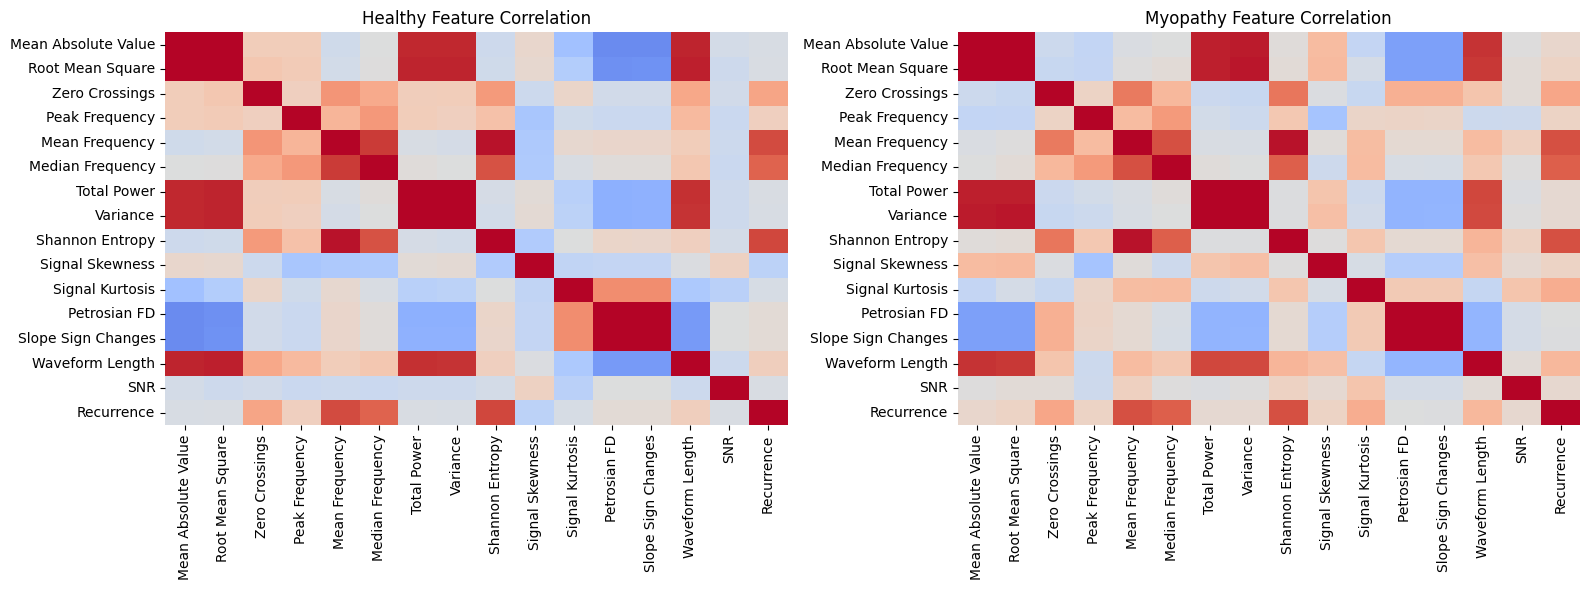

In [34]:
# Compute correlations
corr_healthy = pd.DataFrame(healthy_vectors, columns=feature_names).corr()
corr_pathology = pd.DataFrame(
    myopathy_vectors if class_option == 1 else neuropathy_vectors, 
    columns=feature_names
).corr()

# Plot heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(corr_healthy, ax=axes[0], cmap='coolwarm', center=0, cbar=False)
axes[0].set_title('Healthy Feature Correlation')

sns.heatmap(corr_pathology, ax=axes[1], cmap='coolwarm', center=0, cbar=False)
axes[1].set_title(f'{pathology_name} Feature Correlation')

plt.tight_layout()
plt.show()


### 🔍 Statistical Summary Insights
The comparative analysis shows that Myopathy recordings have significantly higher variance, waveform length, and signal complexity compared to healthy muscles. 
This indicates stronger and more irregular muscle activations, consistent with neuromuscular dysfunction. 
Correlation heatmaps further highlight increased inter-feature coupling in pathological signals, suggesting a loss of independent control over motor units.


## Data Splitting

In [36]:
# Data Splitting

training_set, validation_set, test_set = create_train_val_test_sets(featured_dataset, class_option, random_seed)

In [37]:
print(f"Train set : {len(training_set)}")
print(f"Val   set :  {len(validation_set)}")
print(f"Test  set :  {len(test_set)}")

h = 0
for i in range(len(training_set)):
    if training_set[i]['Class'] == 0:
        h += 1

print(f"\nTrain   Healthy : {h}")
if class_option == 1:
    print(f"Train  Myopathy : {len(training_set)-h}")
else:
    print(f"Train  Neuropathy : {len(training_set)-h}")

h = 0
for i in range(len(validation_set)):
    if validation_set[i]['Class'] == 0:
        h += 1

print(f"\nVal     Healthy :  {h}")
if class_option == 1:
    print(f"Val    Myopathy :  {len(validation_set)-h}")
else:
    print(f"Val  Neuropathy :  {len(validation_set)-h}")

h = 0
for i in range(len(test_set)):
    if test_set[i]['Class'] == 0:
        h += 1

print(f"\nTest    Healthy : {h}")
if class_option == 1:
    print(f"Test   Myopathy : {len(test_set)-h}")
else:
    print(f"Test Neuropathy : {len(test_set)-h}")

Train set : 158
Val   set :  15
Test  set :  24

Train   Healthy : 80
Train  Myopathy : 78

Val     Healthy :  8
Val    Myopathy :  7

Test    Healthy : 12
Test   Myopathy : 12


## Data Preparation

In [38]:
# Data Preparation

(shuffled_training_set, shuffled_validation_set, shuffled_test_set,
 X_train, y_train, X_val, y_val, X_test, y_test) = prepare_data_for_lightgbm(
    training_set, validation_set, test_set, random_seed)

## LightGBM Training

In [39]:
# Define hyperparameters
lgb_hyperparams = {
    'objective': 'multiclass',
    'num_class': 2,
    'boosting_type': 'gbdt',
    'metric': 'multi_error',
    'max_depth': 7,
    'learning_rate': 0.05,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'seed': 42,
    'verbose': -1,
    'num_boost_round': 500
}

In [40]:
# Train model
lgb_model = train_lightgbm(X_train, y_train, X_val, y_val, lgb_hyperparams)

## LightGBM Evaluation

In [41]:
# Evaluate on test set
start = TIME.time()
results = evaluate_lightgbm(lgb_model, X_test, y_test)
end = TIME.time()

evaluation_time = (end-start)/24

print(task_name)
print(f"Accuracy    : {results['Accuracy']:.2f}")
print(f"Sensitivity : {results['Sensitivity']:.2f}")
print(f"Specificity : {results['Specificity']:.2f}")
print('\n')
print(f"Signal processing time   : {signal_processing_time:.3f} s")
print(f"Features extraction time : {features_extraction_time:.3f} s")
print(f"Evaluation time          : {(evaluation_time*1000):.3f} ms")

Healthy vs. Myopathy
Accuracy    : 0.92
Sensitivity : 0.92
Specificity : 0.92


Signal processing time   : 0.030 s
Features extraction time : 0.163 s
Evaluation time          : 0.095 ms


## SHAP

In [42]:
# Compute SHAP values
shap_values_class_0, shap_values_class_1, explainer = compute_shap_values(lgb_model, X_test)

print(f"SHAP values Class 0 shape: {shap_values_class_0.shape}")
print(f"SHAP values Class 1 shape: {shap_values_class_1.shape}")

SHAP values computed
SHAP values Class 0 shape: (24, 16)
SHAP values Class 1 shape: (24, 16)



Feature Importance (sorted by SHAP value):
            Feature  Mean |SHAP|
       Petrosian FD     0.720316
    Waveform Length     0.560439
                SNR     0.508353
     Zero Crossings     0.487626
         Recurrence     0.332772
    Signal Kurtosis     0.226599
     Mean Frequency     0.224290
    Shannon Entropy     0.218669
        Total Power     0.211097
Mean Absolute Value     0.192050
    Signal Skewness     0.181645
   Root Mean Square     0.123361
     Peak Frequency     0.100758
 Slope Sign Changes     0.083916
   Median Frequency     0.077121
           Variance     0.016040

Plot saved to: shap_feature_importance.png


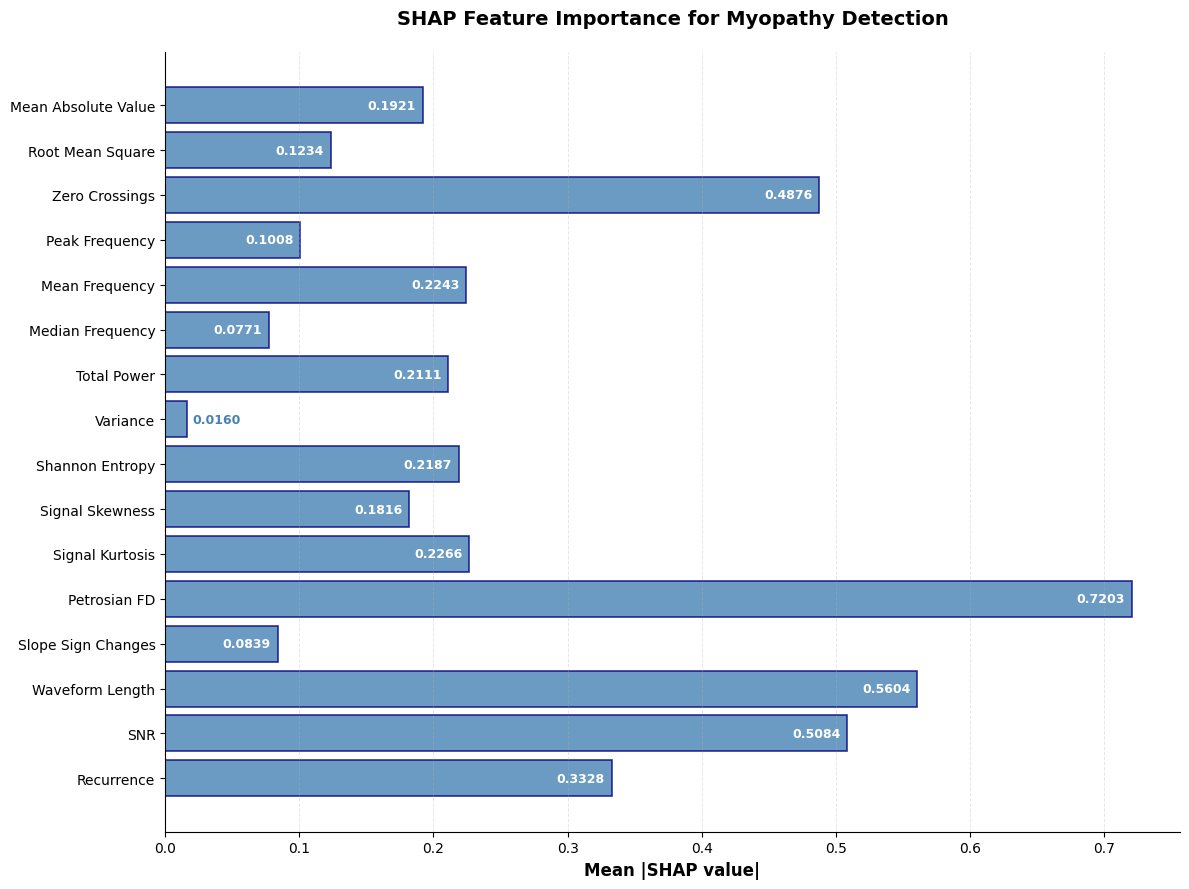

In [48]:
if class_option == 1:
    title = 'SHAP Feature Importance for Myopathy Detection'
if class_option == 2:
    title = 'SHAP Feature Importance for Neuropathy Detection'

# Plot feature importance
plot_shap_feature_importance(
    shap_values_class_1, 
    feature_names, 
    title,
    save_path='shap_feature_importance.png'
)


Plot saved to: shap_summary_plot.png


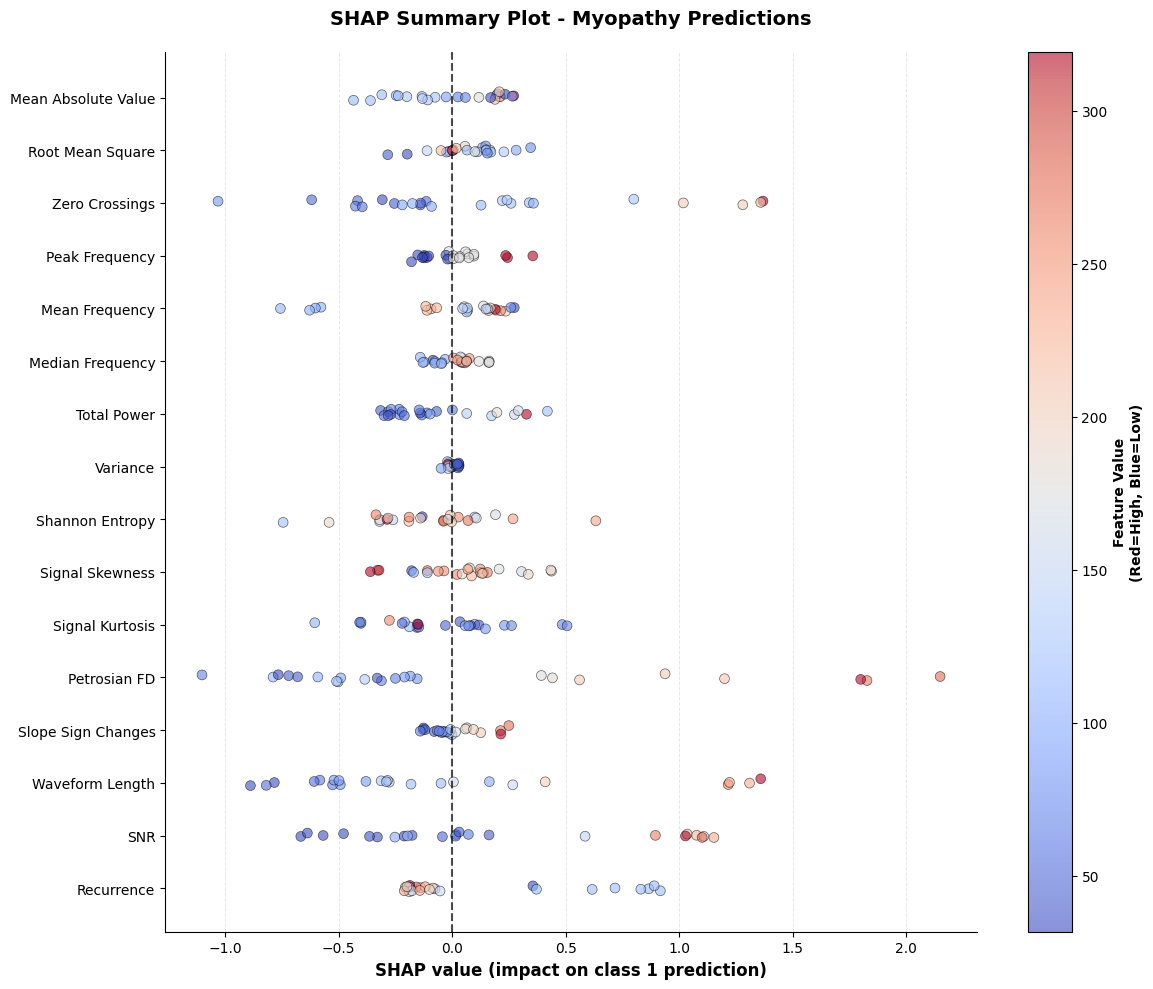

In [49]:
if class_option == 1:
    title = 'SHAP Summary Plot - Myopathy Predictions'
if class_option == 2:
    title = 'SHAP Summary Plot - Neuropathy Predictions'

plot_shap_summary(
    shap_values_class_1, 
    X_test, 
    feature_names,
    title,
    save_path='shap_summary_plot.png'
)

SAMPLE 23 ANALYSIS
File Name: EMG _033 _17_ RD_Hea.asc
True Class: 0 (Healthy)
Predicted Class: 0 (Healthy)
Prediction Probabilities: Class 0=0.57246, Class 1=0.42754
Base rate (expected value): -0.6127

Feature Contributions:
            Feature         Value      SHAP Impact
Mean Absolute Value  1.420597e+02 -0.131967      ↓
   Root Mean Square  2.035367e+02 -0.111133      ↓
     Zero Crossings  1.704000e+03 -0.396605      ↓
     Peak Frequency  1.280000e+02  0.030729      ↑
     Mean Frequency  2.060966e+02  0.148147      ↑
   Median Frequency  1.920000e+02  0.162141      ↑
        Total Power  6.471582e+02 -0.097696      ↓
           Variance  4.142718e+04 -0.049409      ↓
    Shannon Entropy  2.906224e+00 -0.019102      ↓
    Signal Skewness -1.583424e+00 -0.170423      ↓
    Signal Kurtosis  4.620155e+00  0.072550      ↑
       Petrosian FD  1.004402e+00 -0.250398      ↓
 Slope Sign Changes  5.205000e+03 -0.057395      ↓
    Waveform Length  9.267302e+05 -0.049701      ↓
        

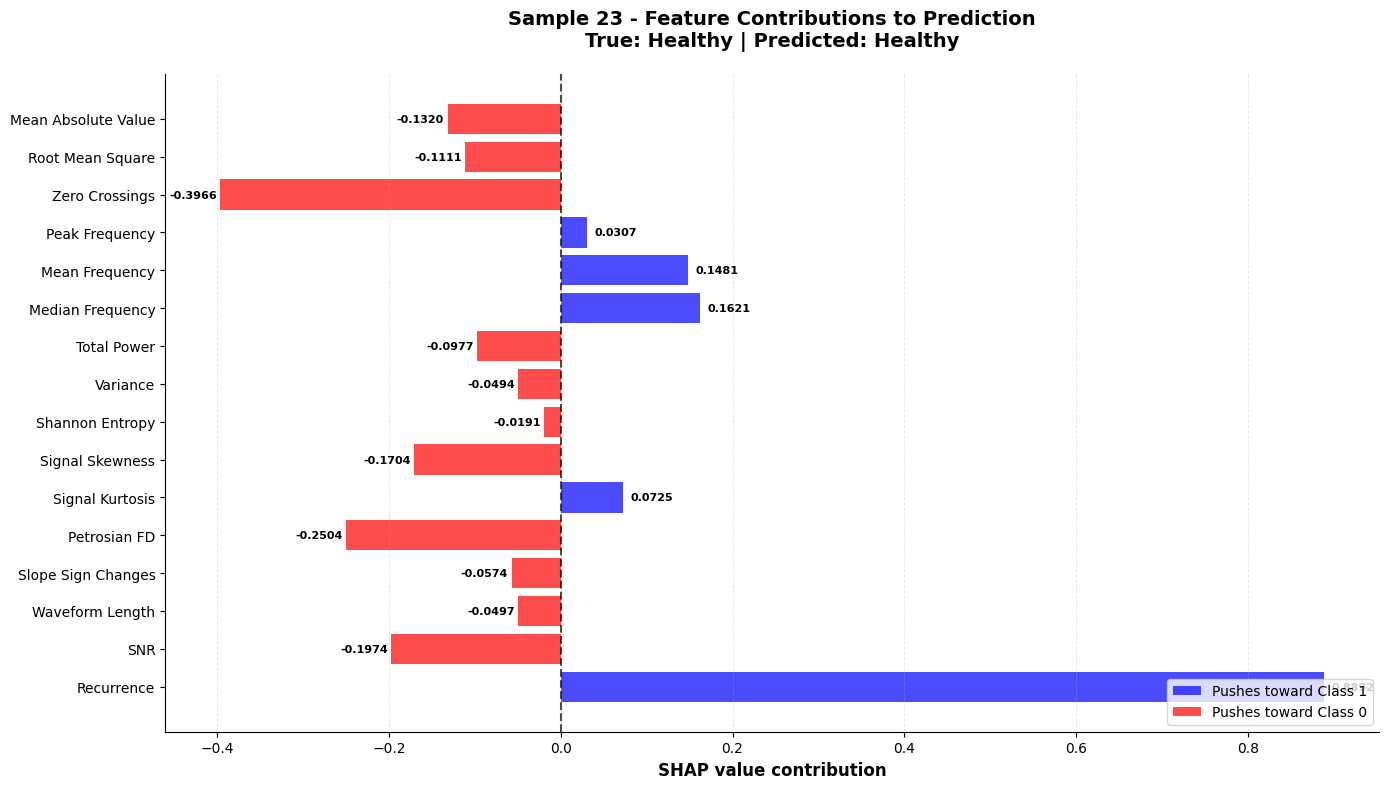

In [50]:
# pick a test sample index (from 0 to 23) and show the force_plot
sample_idx = 23

shap_vals = plot_force_plot(
    model=lgb_model,
    class_option = class_option,
    shap_values_class_1=shap_values_class_1,
    X_test=X_test,
    shuffled_test_set=shuffled_test_set,
    feature_names=feature_names,
    sample_idx=sample_idx,
    explainer=explainer,
    save_path=f'force_plot_sample_{sample_idx}.png'
)

⚠️ Misclassified sample found at index 0
SAMPLE 0 ANALYSIS
File Name: EMG _344 _92_ RB_Myo.asc
True Class: 1 (Myopathy)
Predicted Class: 0 (Healthy)
Prediction Probabilities: Class 0=0.97409, Class 1=0.02591
Base rate (expected value): -0.6127

Feature Contributions:
            Feature         Value      SHAP Impact
Mean Absolute Value  1.146406e+02 -0.310456      ↓
   Root Mean Square  1.649429e+02  0.132897      ↑
     Zero Crossings  2.266000e+03  0.258623      ↑
     Peak Frequency  1.280000e+02  0.066932      ↑
     Mean Frequency  2.783643e+02  0.193093      ↑
   Median Frequency  1.920000e+02  0.046483      ↑
        Total Power  4.131232e+02 -0.232741      ↓
           Variance  2.720616e+04 -0.003076      ↓
    Shannon Entropy  3.522835e+00  0.026269      ↑
    Signal Skewness -4.388455e-01  0.123340      ↑
    Signal Kurtosis  5.642148e+00 -0.402440      ↓
       Petrosian FD  1.005538e+00 -0.789236      ↓
 Slope Sign Changes  6.583000e+03 -0.061093      ↓
    Waveform Lengt

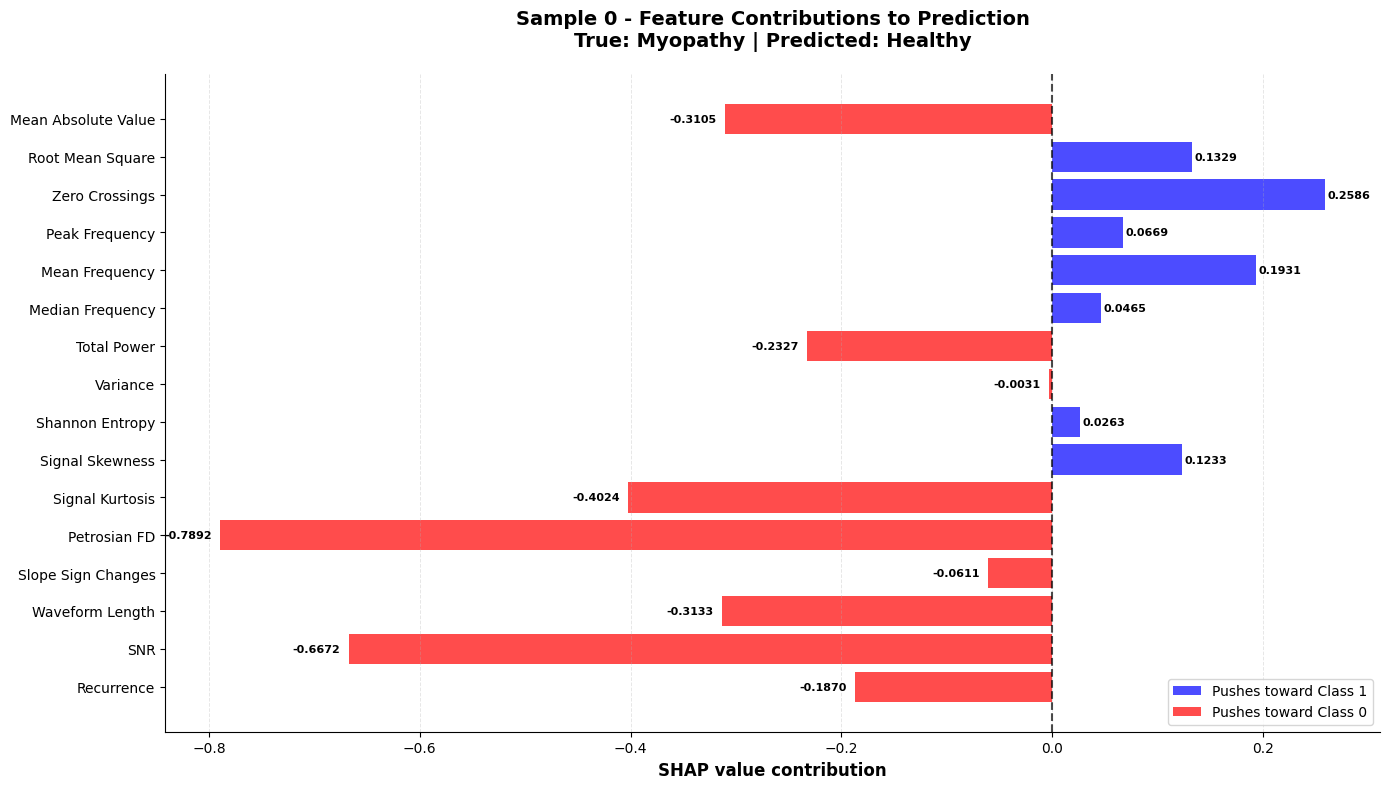

In [51]:
# Find a misclassified sample (predicted != true)
import numpy as np

misclassified_indices = []
for i in range(len(shuffled_test_set)):
    pred_proba = lgb_model.predict([X_test[i]])[0]
    pred_class = int(pred_proba[1] > 0.5)
    true_class = shuffled_test_set[i]['Class']
    if pred_class != true_class:
        misclassified_indices.append(i)

if len(misclassified_indices) == 0:
    print("✅ All test samples were correctly classified!")
else:
    # Pick the first misclassified one
    sample_idx = misclassified_indices[0]
    print(f"⚠️ Misclassified sample found at index {sample_idx}")
    
    shap_vals = plot_force_plot(
        model=lgb_model,
        class_option=class_option,
        shap_values_class_1=shap_values_class_1,
        X_test=X_test,
        shuffled_test_set=shuffled_test_set,
        feature_names=feature_names,
        sample_idx=sample_idx,
        explainer=explainer,
        save_path=f'force_plot_misclassified_{sample_idx}.png'
    )


In [52]:
# Count correct pushes for each feature
correct_pushes = count_correct_pushes(
    shap_values_class_0, 
    shap_values_class_1, 
    y_test, 
    feature_names
)


FEATURE CORRECT PUSH COUNTS
Total test samples: 24

How many times each feature pushed toward the CORRECT class:
----------------------------------------------------------------------
Mean Absolute Value      :  15 / 24 ( 62.5%)
Root Mean Square         :  12 / 24 ( 50.0%)
Zero Crossings           :  19 / 24 ( 79.2%)
Peak Frequency           :  20 / 24 ( 83.3%)
Mean Frequency           :  12 / 24 ( 50.0%)
Median Frequency         :  17 / 24 ( 70.8%)
Total Power              :  12 / 24 ( 50.0%)
Variance                 :  14 / 24 ( 58.3%)
Shannon Entropy          :  13 / 24 ( 54.2%)
Signal Skewness          :  15 / 24 ( 62.5%)
Signal Kurtosis          :  13 / 24 ( 54.2%)
Petrosian FD             :  16 / 24 ( 66.7%)
Slope Sign Changes       :  16 / 24 ( 66.7%)
Waveform Length          :  16 / 24 ( 66.7%)
SNR                      :  15 / 24 ( 62.5%)
Recurrence               :  10 / 24 ( 41.7%)


### Helper function to compute SHAP interaction values

In [53]:
def compute_shap_interactions(model, X_test, feature_names):
    """
    Compute SHAP interaction values for a LightGBM model.

    Parameters:
    - model: trained LightGBM model
    - X_test: list or array of feature vectors
    - feature_names: list of feature names (length n_features)

    Returns:
    - interactions: numpy array (n_samples, n_features, n_features)
    - mean_interactions: DataFrame of mean |interaction| per feature pair
    """
    import shap
    import numpy as np
    import pandas as pd

    # Convert test set to numpy array
    X_test_array = np.array(X_test)

    # Initialize SHAP explainer
    explainer = shap.TreeExplainer(model)

    print("Computing SHAP interaction values... (this may take a bit)")
    interactions = explainer.shap_interaction_values(X_test_array)

    # Handle multiclass case: use class 1 interactions
    if isinstance(interactions, list):
        interactions = interactions[1]

    # Compute mean absolute interaction strength per feature pair
    mean_abs_interactions = np.abs(interactions).mean(axis=0)

    mean_interactions_df = pd.DataFrame(
        mean_abs_interactions,
        columns=feature_names,
        index=feature_names
    )

    print("✅ SHAP interaction matrix computed successfully!")
    return interactions, mean_interactions_df


### Helper function to visualize top interactions (heatmap)

In [54]:
def plot_top_shap_interactions(mean_interactions_df, top_n=10, save_path=None):
    """
    Plot the strongest SHAP feature interactions as a heatmap.

    Parameters:
    - mean_interactions_df: DataFrame of mean |interaction| per feature pair
    - top_n: int, number of top interacting pairs to display
    - save_path: str, optional path to save the plot
    """
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    # Melt to long form and remove self-interactions
    df_long = mean_interactions_df.copy()
    np.fill_diagonal(df_long.values, np.nan)
    df_melted = df_long.reset_index().melt(id_vars='index', var_name='Feature 2', value_name='Interaction')
    df_melted.rename(columns={'index': 'Feature 1'}, inplace=True)
    df_melted = df_melted.dropna().sort_values('Interaction', ascending=False)

    # Top N pairs
    top_pairs = df_melted.head(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_pairs, x='Interaction', y='Feature 1', hue='Feature 2', dodge=False, palette='viridis')
    plt.title(f"Top {top_n} Strongest SHAP Feature Interactions", fontsize=14, fontweight='bold')
    plt.xlabel("Mean |Interaction Value|")
    plt.ylabel("Primary Feature")
    plt.legend(title="Interacting Feature", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")

    plt.show()


Computing SHAP interaction values... (this may take a bit)
✅ SHAP interaction matrix computed successfully!
Plot saved to: shap_top_interactions.png


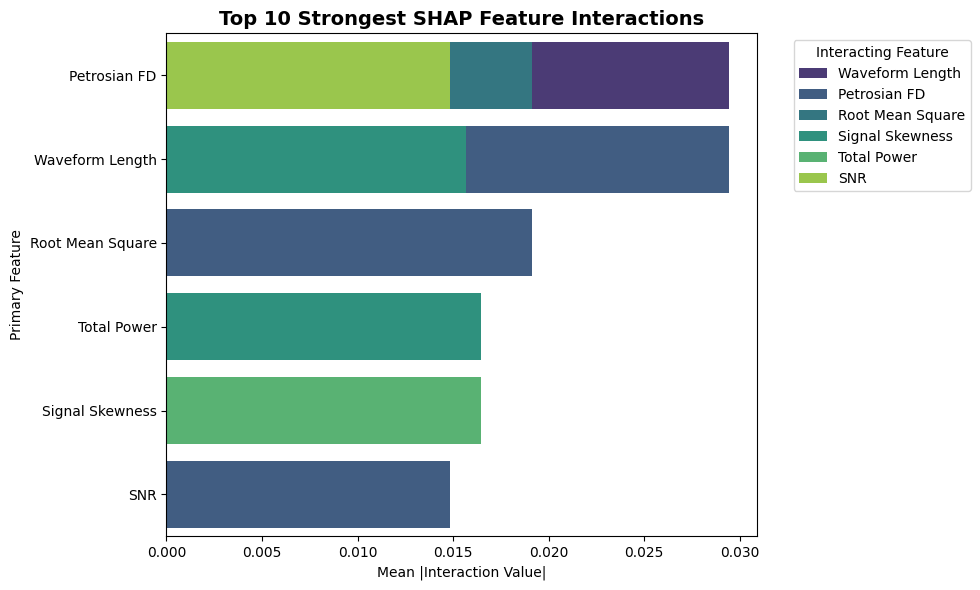

In [55]:
# Compute SHAP interaction matrix
interactions, mean_interactions_df = compute_shap_interactions(
    model=lgb_model,
    X_test=X_test,
    feature_names=feature_names
)

# Visualize strongest pairs
plot_top_shap_interactions(mean_interactions_df, top_n=10, save_path='shap_top_interactions.png')


Heatmap saved to: shap_interaction_heatmap.png


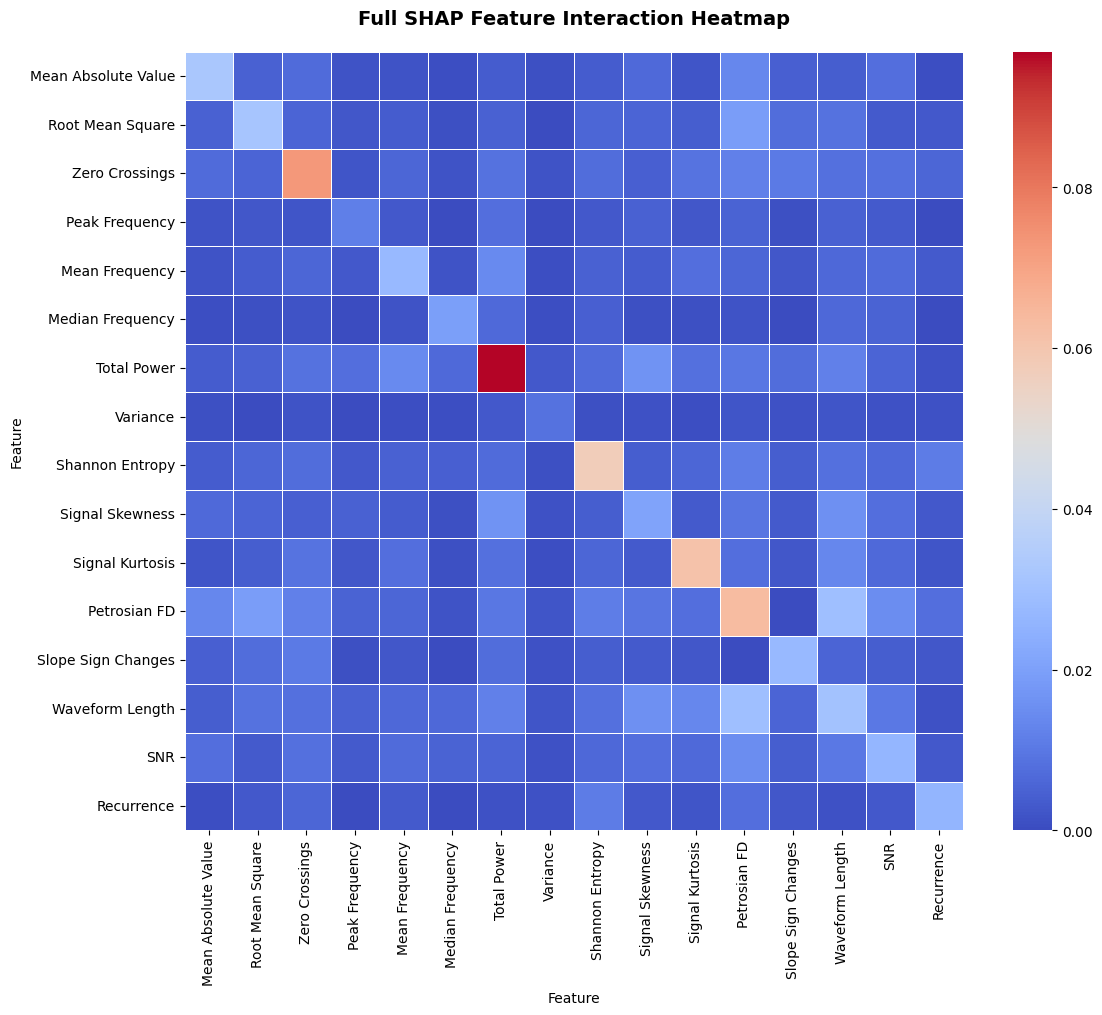

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_shap_interaction_heatmap(mean_interactions_df, save_path=None):
    """
    Plot the full SHAP feature interaction matrix as a heatmap.
    """
    plt.figure(figsize=(12, 10))
    sns.heatmap(mean_interactions_df, cmap='coolwarm', square=True, linewidths=0.5)
    plt.title("Full SHAP Feature Interaction Heatmap", fontsize=14, fontweight='bold', pad=20)
    plt.xlabel("Feature")
    plt.ylabel("Feature")
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Heatmap saved to: {save_path}")
    plt.show()

# Example call
plot_shap_interaction_heatmap(mean_interactions_df, save_path='shap_interaction_heatmap.png')
